# Distributions

Look at some of the data

In [5]:
"""Setup"""

%load_ext pyinstrument

import numpy as np
import sys
#from google.colab import drive
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
import numpy as np
from matplotlib.patches import Circle, Rectangle
from mpl_toolkits.mplot3d import Axes3D
from viz import *
from optics import *

#drive.mount("/content/gdrive")
np.set_printoptions(
    edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x)
)
# the code in this notebook is formatted with Black https://black.vercel.app/ using 3.7, which is what this says:
print(sys.version)

The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument
3.8.10 (default, Jun 22 2022, 20:18:18) 
[GCC 9.4.0]


"Relative Luminous Intensity" from the [Cree XP-E2 datasheet](https://cree-led.com/media/documents/XLampXPE2.pdf)

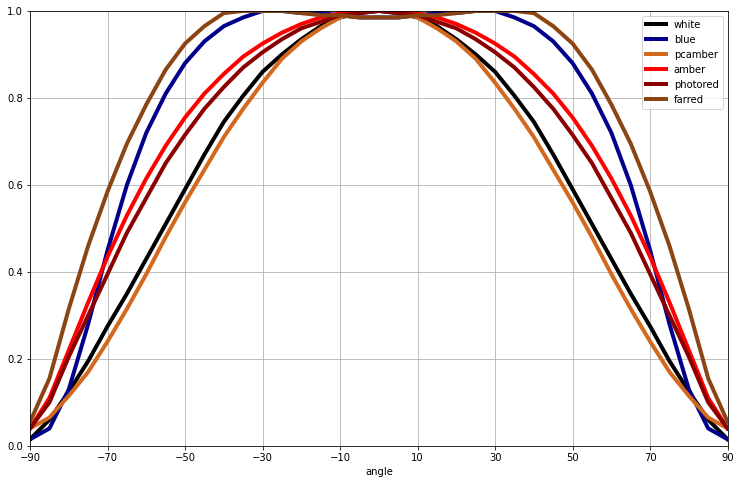

_     ._   __/__   _ _  _  _ _/_   Recorded: 22:07:41  Samples:  327
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.337     CPU time: 0.336
/   _/                      v4.2.0

Program: /home/joel/.local/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/joel/.local/share/jupyter/runtime/kernel-41453182-b484-45a9-9f15-a972456a7a76.json

0.336 <module>  <ipython-input-6-13faaab68984>:2
|- 0.192 show_cree_data  <ipython-input-6-13faaab68984>:23
|  `- 0.192 __call__  pandas/plotting/_core.py:891
|        [644 frames hidden]  pandas, pkg_resources, re, <built-in>...
`- 0.140 <module>  pandas/__init__.py:3
      [379 frames hidden]  pandas, <built-in>, dataclasses, text...

In [6]:
%%pyinstrument
""" Show Cree XP-E2 data."""
import pandas as pd


def get_cree_data():
    # spatial-distribution.txt data is eyeballed from https://cree-led.com/media/documents/XLampXPE2.pdf, page 20.
    df = pd.read_csv(
#        "/content/gdrive/MyDrive/spatial-distribution.txt", delim_whitespace=True
        "spatial-distribution.txt", delim_whitespace=True
    )
    return df

def mirror(df):
    """ Mirror the data on the negative side of the angle scale, for visualization."""
    # The angle is the polar angle, so it is never negative, but it's common to visualize
    # on a [-90,90] scale.
    df2 = df.copy()
    df2["angle"] = df2["angle"] * -1
    df3 = pd.concat([df, df2])
    df3 = df3.sort_values(by=["angle"])
    return df3

def show_cree_data(df3):
    """ Duplicates the charts on page 20."""
    ax = df3.plot(
        x="angle",
        color=["black", "darkblue", "chocolate", "red", "darkred", "saddlebrown"],
        xlim=[-90, 90],
        ylim=[0, 1],
        grid=True,
        figsize=[12.5, 8],
        linewidth=4,
        xticks=[-90, -70, -50, -30, -10, 10, 30, 50, 70, 90],
    )


cree_spatial_distribution = get_cree_data()
cree_spatial_distribution_both_sides = mirror(cree_spatial_distribution)
show_cree_data(cree_spatial_distribution_both_sides)

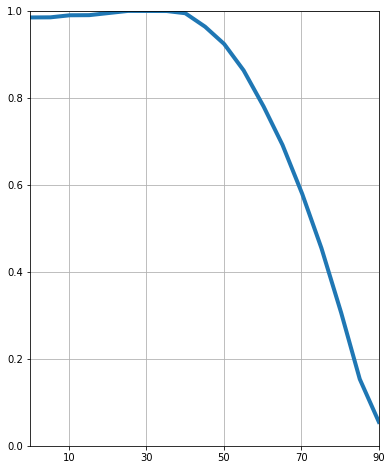

In [3]:
""" Show interpolated spatial distribution.

To use the Cree data above, I need a continuous version of it; try interp1d.
"""
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate


def make_interpolated_spatial_distribution(cree_data):
    farred = interpolate.interp1d(cree_data["angle"], cree_data["farred"])
    x_new = np.arange(0, 90, 0.001)
    y_new = farred(x_new)
    return pd.DataFrame({"angle": x_new, "farred": y_new})


def show_interpolated_spatial_distribution(df_interp):
    plt.figure(figsize=[6.25, 8])
    ax = plt.subplot()
    plt.plot(df_interp["angle"], df_interp["farred"], "-", linewidth=4)
    ax.grid(True)
    ax.set_xlim(0, 90)
    ax.set_ylim(0, 1)
    ax.set_xticks([10, 30, 50, 70, 90])


cree_spatial_distribution_interpolated = make_interpolated_spatial_distribution(
    cree_spatial_distribution
)
show_interpolated_spatial_distribution(cree_spatial_distribution_interpolated)



Polar coordinates.  "Photo Red" is the most nearly Lambertian.

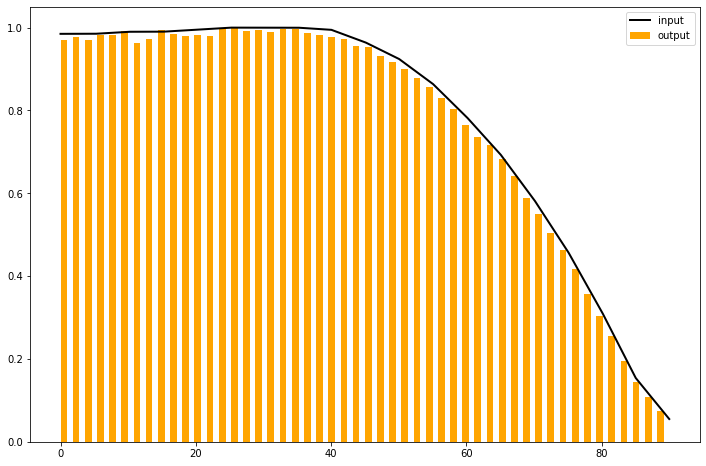

In [4]:
""" Show how to generate random numbers matching a given distribution.

Cribbed from https://stackoverflow.com/questions/17821458/random-number-from-histogram
"""

def generate_rand_from_pdf(pdf: pd.Series, x_grid: pd.Series) -> pd.Series:
    cdf = pdf.cumsum()
    cdf = cdf / cdf.iloc[-1]
    values = np.random.rand(1000000)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf

def show_histogram_fit():
    given_x: pd.Series = cree_spatial_distribution_interpolated['angle']
    given_pdf: pd.Series = cree_spatial_distribution_interpolated['farred']
    random_from_cdf: pd.Series = generate_rand_from_pdf(given_pdf, given_x)

    f = plt.figure(figsize=[12,8])
    plt.plot(given_x, given_pdf, '-', linewidth=2, label='input', color='black')
    counts, bins = np.histogram(random_from_cdf, 50)
    plt.hist(bins[:-1], bins, weights=counts/counts.max(), color='orange', label='output', width=1)
    plt.legend();

show_histogram_fit()

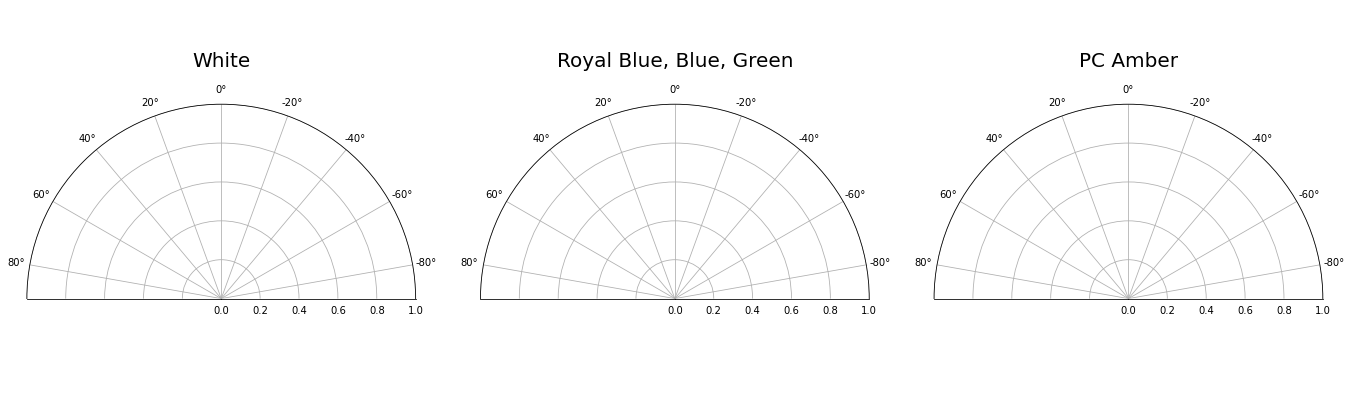

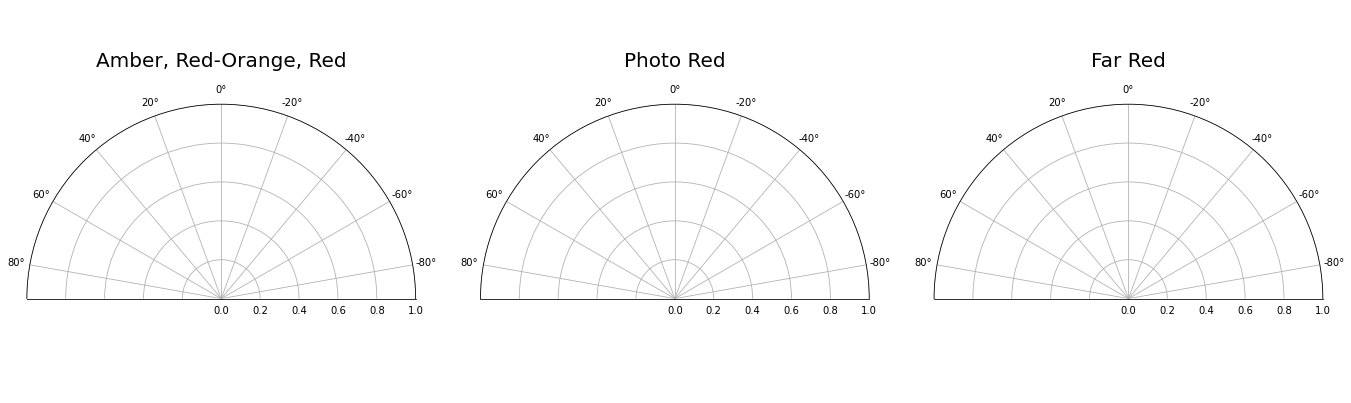

In [5]:
""" Show spatial distribution in polar coordinates."""
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.transforms import Bbox


def show_cree_data_polar(df3):
    df4 = df3.copy()
    df4["radians"] = df4["angle"] * np.pi / 180
    # there are two figures here because I couldn't figure out how to make the half-polar plots
    # the right size in a grid.
    titles = ["White", "Royal Blue, Blue, Green", "PC Amber"]
    columns = ["white", "blue", "pcamber"]
    positions = [131, 132, 133]
    subpositions = [
        [0.0, -0.6, 0.3, 1.4],
        [0.35, -0.6, 0.65, 1.4],
        [0.7, -0.6, 1.0, 1.4],
    ]
    f = plt.figure(figsize=[18, 3])
    for t, c, p, s in zip(titles, columns, positions, subpositions):
        ax = plt.subplot(p, polar=True)
        ax.set_theta_zero_location("N")
        ax.set_thetamin(-90)
        ax.set_thetamax(90)
        ax.set_title(t, pad=-60, fontsize=20)
        bb = Bbox.from_extents(s)
        ax.set_position(bb)
        plt.polar(df4["radians"], df4[c])
        ax.set_rmax(1.0)

    titles = ["Amber, Red-Orange, Red", "Photo Red", "Far Red"]
    columns = ["amber", "photored", "farred"]

    f = plt.figure(figsize=[18, 3])
    for t, c, p, s in zip(titles, columns, positions, subpositions):
        ax = plt.subplot(p, polar=True)
        ax.set_theta_zero_location("N")
        ax.set_thetamin(-90)
        ax.set_thetamax(90)
        ax.set_title(t, pad=-60, fontsize=20)
        bb = Bbox.from_extents(s)
        ax.set_position(bb)
        plt.polar(df4["radians"], df4[c])
        ax.set_rmax(1.0)


show_cree_data_polar(cree_spatial_distribution_both_sides)


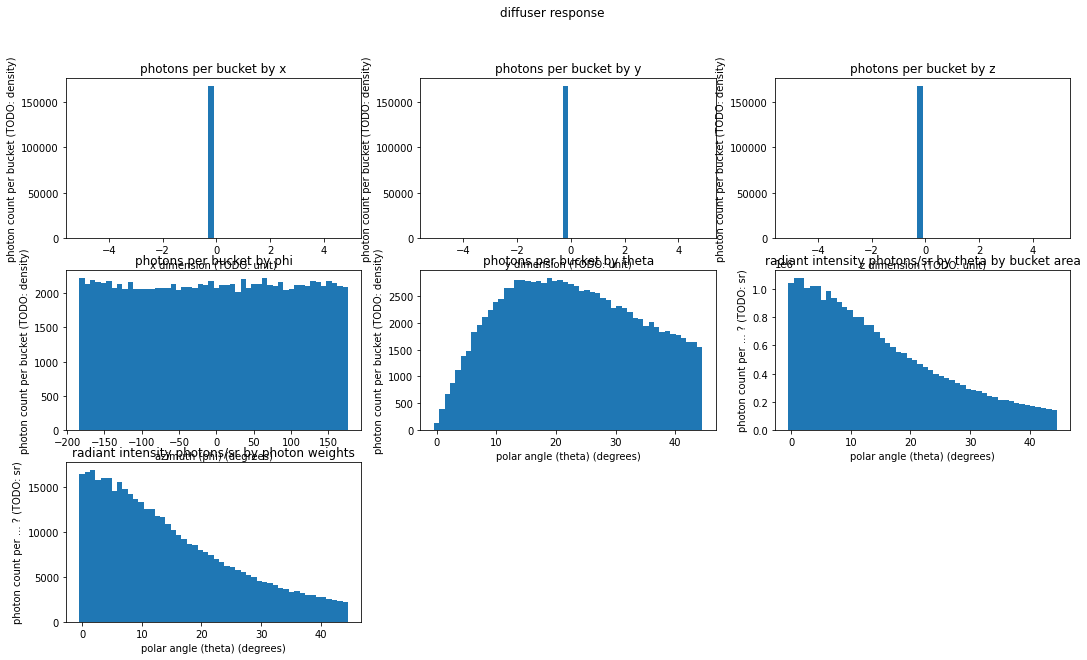

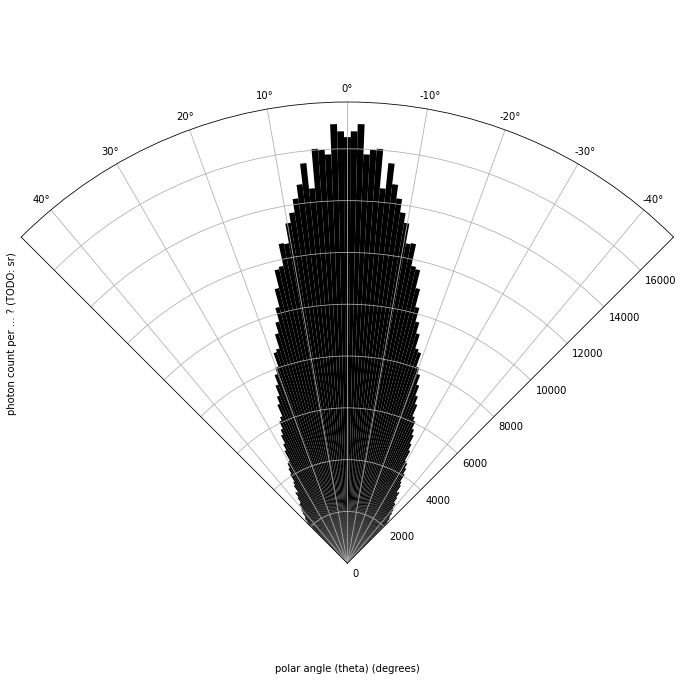

In [6]:
""" Show the intensity plot for the diffuser.

The plan is to use Acrylite 0D010DF in the 0.118 thickness, available at Tap plastics.
It is described here:
https://www.acrylite.co/files/content/acrylite.co/documents/product-information/satinice/ACRYLITE-Satinice-Enhanced-Acrylic.pdf
as producing 40-degree FWHM scattering. 
"""
def verify_diffuser():
    photons = PencilSource().make_photons(200000) # pretty high resolution
    diffuser = Diffuser(g = 0.64, absorption = 0.16) # from datasheet
    diffuser.diffuse(photons)
    plot_histogram_slices(photons, "diffuser response", x_min=-5, x_max=5, y_min=-5, y_max=5, z_min=-5, z_max=5, theta_min=0, theta_max=np.pi/4, bins=50)

verify_diffuser()


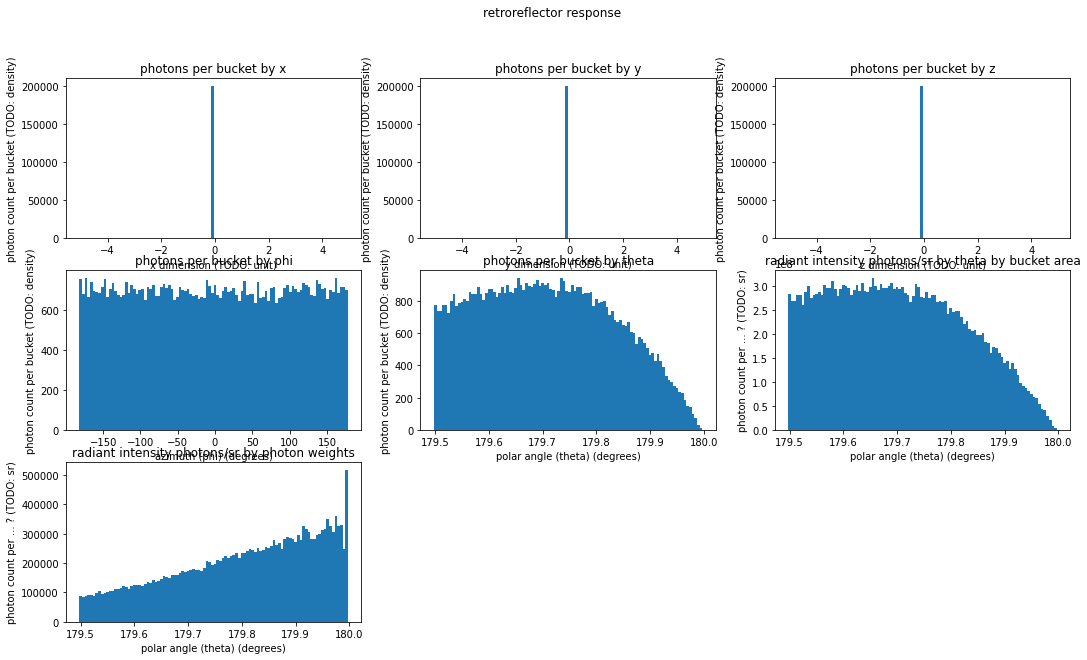

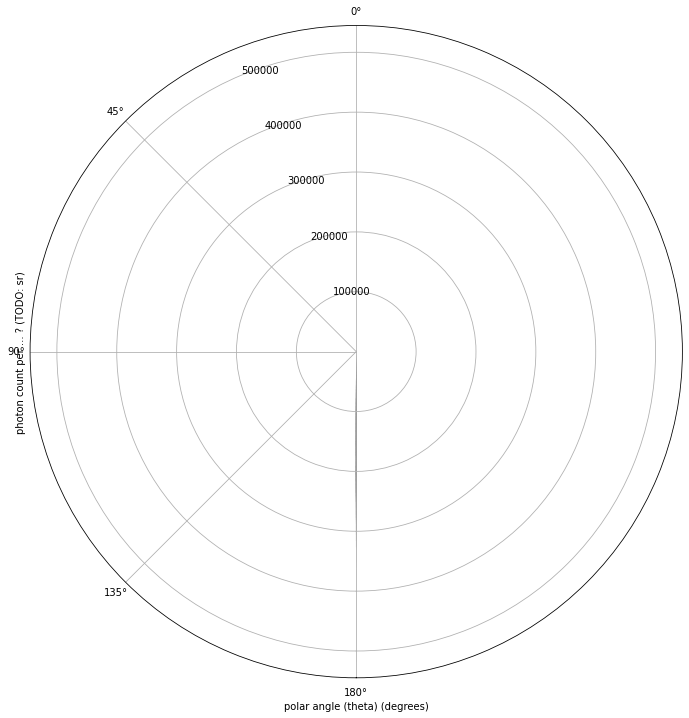

In [7]:
""" Show the intensity plot for the reflector.

FRC uses 3M Scotchlite, which has a reflection coefficient, R_A, of 500 at 0.2 degrees.
"""
def verify_reflector():
    photons = PencilSource().make_photons(200000) # pretty high resolution
    reflector = Diffuser(g = -0.9925, absorption = 0)
    reflector.diffuse(photons)

    plot_histogram_slices(photons, "retroreflector response", x_min=-5, x_max=5, y_min=-5, y_max=5, z_min=-5, z_max=5, theta_min=179.5*np.pi/180, theta_max=np.pi, bins=100)

verify_reflector()